## 20220829
- 看PSNR統計圖可以知道，沒有embedded的block不用整個做偏移，會影響PSNR
- check遷入之後的正確性

# 1. JPEG Compression

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
import copy
from pprint import pprint
from pathlib import Path
from tqdm import tqdm, trange
sys.path.insert(1, '../')

from JPEG import JPEG
from libs.util import psnr

In [2]:
image_path = "../../_Dataset/Basic/Lena.tiff"
isColor = False
quality = 70

def JPEG_Blocks(image_path, quality, isColor):
    jpeg_encoder = JPEG(image_path)
    jpeg_encoder.useStandardHuffmanTable()
    # jpeg_encoder.encode(quality=50, save_path="./test")
    jpeg_encoder.block_size = 8
    jpeg_encoder.quality = quality

    jpeg_encoder.ColorComp(isColor)
    jpeg_encoder._img2ycbcr(isColor=jpeg_encoder.ColorImage)
    jpeg_encoder._ycbcrFDCT()
    jpeg_encoder._ycbcrQuant()
    Blocks = jpeg_encoder._ycbcrZigzag()
    return Blocks

Blocks = JPEG_Blocks(image_path, quality, isColor)

# 2. Selection of Corfficients for RDH

In [3]:
Blocks[0]

[array([26,  1,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])]

In [4]:
def histogram(hist, ax, bins=161, title=""):
    df = pd.DataFrame(hist)
    return df.hist(bins=bins, ax=ax, column=title)

def histByZBlocks(blocks):
    DC_hist, AC_hist, ZeroAC_hist = [], [], []
    for zblock_index in trange(len(blocks)):
        for comp_block_index in range(len(blocks[zblock_index])):
            DC_hist.append(blocks[zblock_index][comp_block_index][0])
            for e in blocks[zblock_index][comp_block_index][1:]:
                if e != 0:
                    AC_hist.append(e)
                ZeroAC_hist.append(e)
            AC_hist.append(0)

    return DC_hist, AC_hist, ZeroAC_hist

def Difference_by_DChist(DC_hist):
    d = 3 if isColor else 1
    last_DC = np.zeros(d)
    DiffDC_hist = []
    for DC_hist_index in range(len(DC_hist)):
        DiffDC_hist.append(DC_hist[DC_hist_index] - last_DC[DC_hist_index%d])
        last_DC[DC_hist_index%d] = DC_hist[DC_hist_index]
    return DiffDC_hist

quality_list = [70, 80, 90, 100]
HistOfAllDC = {"Quality_Type": [], "Hist": [], "Diff_Hist": []}
HistOfAllAC = {"Quality_Type": [], "Hist": []}
HistOfAllnonZeorAC = {"Quality_Type": [], "Hist": []}
HistOfAllnonZeorACisOdd = {"Quality_Type": [], "Hist": []}

for quality_index in range(len(quality_list)):
    Blocks = JPEG_Blocks(image_path, quality_list[quality_index], isColor)
    _DC_hist, _AC_hist, _Zero_AC_hist = histByZBlocks(Blocks)
    _DiffDC_hist = Difference_by_DChist(_DC_hist)
    for dc_index in range(len(_DC_hist)):
        HistOfAllDC["Quality_Type"].append("({})".format(hex(10+quality_index)[2]))
        HistOfAllDC["Hist"].append(_DC_hist[dc_index])
        HistOfAllDC["Diff_Hist"].append(_DiffDC_hist[dc_index])
    for ac_index in range(len(_AC_hist)):
        HistOfAllnonZeorAC["Quality_Type"].append("({})".format(hex(10+quality_index)[2]))
        HistOfAllnonZeorAC["Hist"].append(_AC_hist[ac_index])
        HistOfAllnonZeorACisOdd["Quality_Type"].append("({})".format(hex(10+quality_index)[2]))
        HistOfAllnonZeorACisOdd["Hist"].append(_AC_hist[ac_index]&1)
    for ac_index in range(len(_Zero_AC_hist)):
        HistOfAllAC["Quality_Type"].append("({})".format(hex(10+quality_index)[2]))
        HistOfAllAC["Hist"].append(_Zero_AC_hist[ac_index])

100%|██████████| 4096/4096 [00:00<00:00, 69679.95it/s]


## 2.1 About DC coefficients

In [5]:
DC_df = pd.DataFrame(HistOfAllDC)
DC_df

,Quality_Type,Hist,Diff_Hist
0,(a),26,26.0
1,(a),25,-1.0
2,(a),22,-3.0
3,(a),21,-1.0
4,(a),25,4.0
...,...,...,...
16379,(d),-23,247.0
16380,(d),-271,-248.0
16381,(d),-580,-309.0
16382,(d),-561,19.0


C:\Users\BREND\AppData\Local\Temp\ipykernel_12376\1362496585.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  DC_df.hist(column='Hist', by='Quality_Type', ax=axs2, bins=161, figsize=(10, 10))


Text(0.5, 0.98, 'Histograms of all DC coefficients of the Lena image: (a) QF=70 (b) QF= 80 (c) QF = 90 (d) QF = 100.')

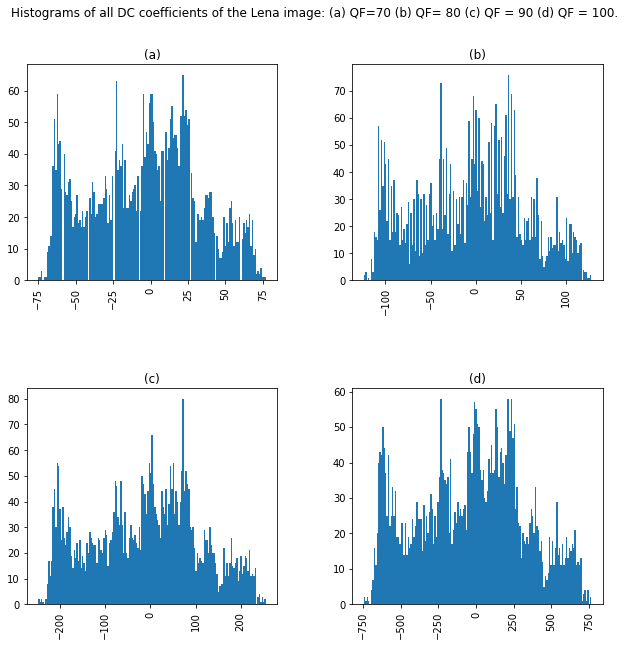

In [6]:
fig2, axs2 = plt.subplots(1, 1, figsize=(10, 10))
DC_df.hist(column='Hist', by='Quality_Type', ax=axs2, bins=161, figsize=(10, 10))
fig2.suptitle("Histograms of all DC coefficients of the Lena image: (a) QF=70 (b) QF= 80 (c) QF = 90 (d) QF = 100.")

C:\Users\BREND\AppData\Local\Temp\ipykernel_12376\3929239768.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  DC_df.hist(column='Diff_Hist', by='Quality_Type', ax=axs3, bins=161, figsize=(10, 10))


Text(0.5, 0.98, 'Difference histograms of all DC coefficients of the Lena image: (a) QF=70 (b) QF= 80 (c) QF = 90 (d) QF = 100.')

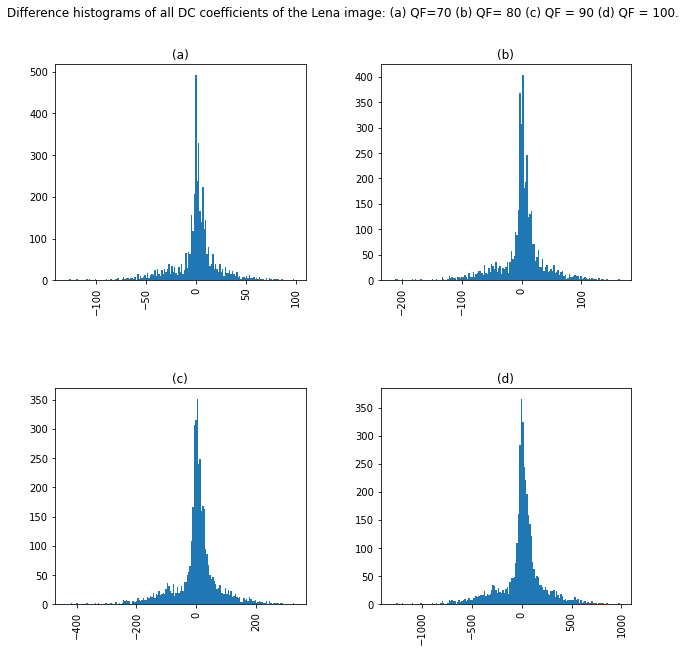

In [7]:
fig3, axs3 = plt.subplots(1, 1, figsize=(10, 10))
DC_df.hist(column='Diff_Hist', by='Quality_Type', ax=axs3, bins=161, figsize=(10, 10))
fig3.suptitle("Difference histograms of all DC coefficients of the Lena image: (a) QF=70 (b) QF= 80 (c) QF = 90 (d) QF = 100.")

## 2.2 About AC coefficients

C:\Users\BREND\AppData\Local\Temp\ipykernel_12376\3649394248.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  AC_df.hist(column='Hist', by='Quality_Type', ax=axs4, bins=161, figsize=(10, 10))


,Quality_Type,Hist
0,(a),1
1,(a),1
2,(a),-1
3,(a),0
4,(a),0
...,...,...
1032187,(d),2
1032188,(d),-2
1032189,(d),2
1032190,(d),1


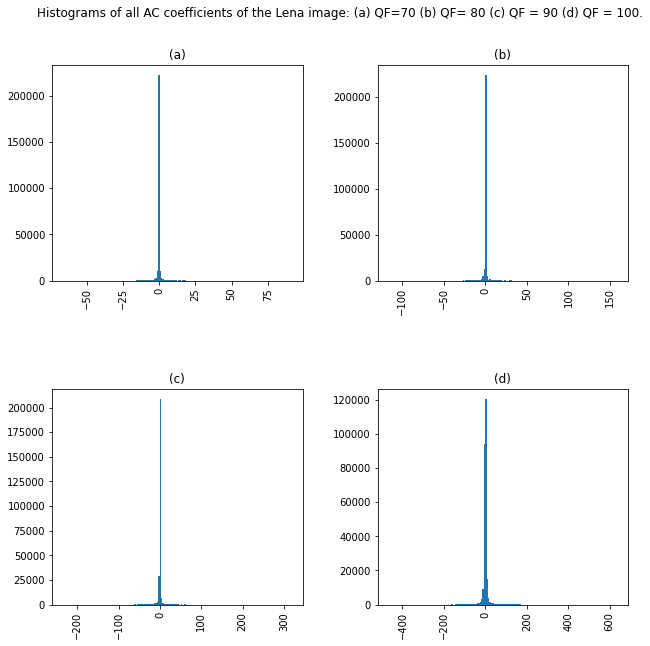

In [8]:
AC_df = pd.DataFrame(HistOfAllAC)

fig4, axs4 = plt.subplots(1, 1, figsize=(10, 10))
AC_df.hist(column='Hist', by='Quality_Type', ax=axs4, bins=161, figsize=(10, 10))
fig4.suptitle("Histograms of all AC coefficients of the Lena image: (a) QF=70 (b) QF= 80 (c) QF = 90 (d) QF = 100.")
AC_df

C:\Users\BREND\AppData\Local\Temp\ipykernel_12376\3213959858.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  nonZeroAC_df.hist(column='Hist', by='Quality_Type', ax=axs6, bins=161, figsize=(10, 10))


,Quality_Type,Hist
0,(a),1
1,(a),1
2,(a),-1
3,(a),0
4,(a),2
...,...,...
395897,(d),-2
395898,(d),2
395899,(d),1
395900,(d),2


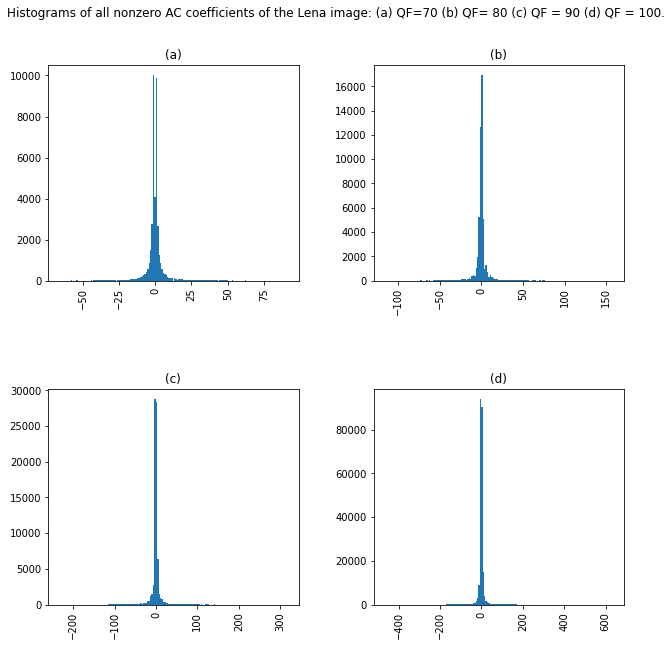

In [9]:
nonZeroAC_df = pd.DataFrame(HistOfAllnonZeorAC)

fig6, axs6 = plt.subplots(1, 1, figsize=(10, 10))
nonZeroAC_df.hist(column='Hist', by='Quality_Type', ax=axs6, bins=161, figsize=(10, 10))
fig6.suptitle("Histograms of all nonzero AC coefficients of the Lena image: (a) QF=70 (b) QF= 80 (c) QF = 90 (d) QF = 100.")
nonZeroAC_df

C:\Users\BREND\AppData\Local\Temp\ipykernel_12376\4100906562.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  nonZeroACisOdd_df.hist(column='Hist', by='Quality_Type', ax=axs7, bins=161, figsize=(10, 10))


,Quality_Type,Hist
0,(a),1
1,(a),1
2,(a),1
3,(a),0
4,(a),0
...,...,...
395897,(d),0
395898,(d),0
395899,(d),1
395900,(d),0


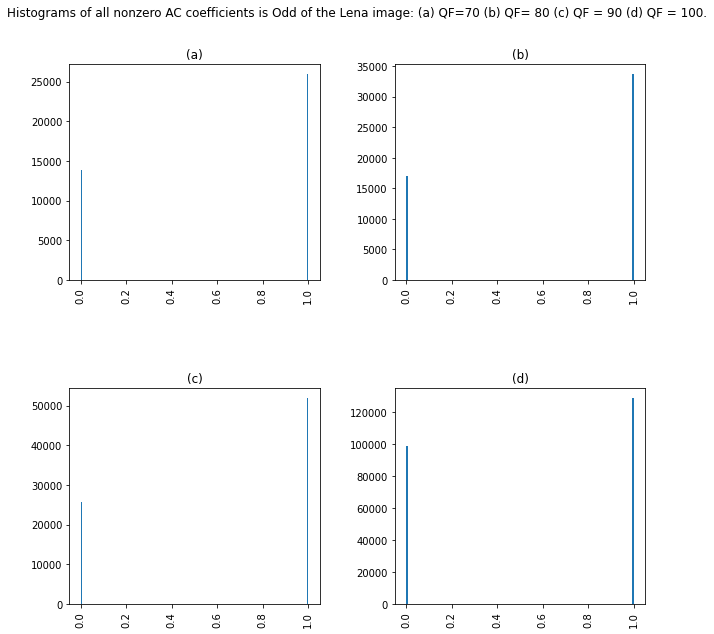

In [10]:
nonZeroACisOdd_df = pd.DataFrame(HistOfAllnonZeorACisOdd)

fig7, axs7 = plt.subplots(1, 1, figsize=(10, 10))
nonZeroACisOdd_df.hist(column='Hist', by='Quality_Type', ax=axs7, bins=161, figsize=(10, 10))
fig7.suptitle("Histograms of all nonzero AC coefficients is Odd of the Lena image: (a) QF=70 (b) QF= 80 (c) QF = 90 (d) QF = 100.")
nonZeroACisOdd_df

# 3. Embedding, Extraction, and Restoration Algorithm

In [5]:
test_block = Blocks[0][0]
# test_block = [0, 0, 0]
test_block.reshape(8, 8)

NameError: name 'Blocks' is not defined

In [6]:
shuf=((abs(test_block)>1) & (abs(test_block)<3))
shuf.reshape(8, 8)

NameError: name 'test_block' is not defined

In [7]:
test_block[shuf] = test_block[shuf]>2

NameError: name 'test_block' is not defined

In [45]:
image_path = "../../_Dataset/Basic/Lena.tiff"
toGray = True
quality = 70
Tz = 29
Seed = 7

class RDH_Huang:
    def __init__(self, image_path, quality, T=29, Seed=None, toGray=False):
        self.image_path = image_path
        self.jpeg = JPEG(image_path)
        self.jpeg.useStandardHuffmanTable()
        self.jpeg.block_size = 8

        self.jpeg.ColorComp(False if toGray else True)
        self.quality = self.jpeg.quality = quality
        self.Tz = T
        self.S = Seed

        self.Blocks = None
        self.index_list = None
        self.isShuffle = False
        self.Define_Tz = 29
        self.Blocks_Embedded_map = None

    def generateOriginalImage(self, save_path, showImage=False):
        log = dict()
        jpeg_origin = copy.deepcopy(self.jpeg)
        jpeg_origin_image = jpeg_origin.encode(quality=self.quality, save_path=save_path, finished_info=log)
        if showImage:
            plt.imshow(jpeg_origin_image)
            plt.show()
            pprint(log)

    def prepare(self):
        self.jpeg._img2ycbcr(isColor=self.jpeg.ColorImage)
        self.jpeg._ycbcrFDCT()
        self.jpeg._ycbcrQuantforRDH()
        self.Blocks = np.array(self.jpeg._ycbcrZigzag())

    def filterAC(self, T=None):
        if self.Blocks is None:
            self.prepare()

        if T is not None:
            self.Tz = T

        numberOfZeroAC = 0
        numberOfInnerCoefficients = 0
        AC_list = []
        for zblock_index in range(len(self.Blocks)):
            block_channel = []
            for comp_block_index in range(len(self.Blocks[zblock_index])):
                rle = self.Blocks[zblock_index][comp_block_index][1:64]
                inner_index = np.argwhere((rle == 1) | (rle == -1))
                if len(inner_index)>0:
                    ac = {
                        "NumberOfZeroAC": np.count_nonzero(rle == 0), 
                        "NumberOfInnerCoefficients": len(inner_index), 
                        "NonZeroAC_index": (np.squeeze(inner_index).astype(np.uint8) if (len(inner_index)>1) else inner_index.reshape((1, )))
                    }
                    if ac["NumberOfZeroAC"]>self.Tz and len(inner_index)>0:
                        block_channel.append(ac)
                        # print(ac)
            AC_list.append(block_channel)
        return AC_list

    def pre_embed(self):
        if self.isShuffle:
            return 
        self.Blocks_Embedded_map = np.zeros((self.Blocks.shape[0], self.Blocks.shape[1]))
        # for zblock_index in range(len(self.Blocks)):
        #     for comp_block_index in range(len(self.Blocks[zblock_index])):
        #         rle = self.Blocks[zblock_index][comp_block_index][1:64]
        #         inner_index = np.argwhere((rle == 1) | (rle == -1))
        #         if np.count_nonzero(rle == 0)>self.Tz and len(inner_index)>0:
        #             rle = rle + (rle>1) - (rle<-1)
        #             self.Blocks[zblock_index][comp_block_index][1:64] = rle
        self.isShuffle = True

    def shuffle_block(self, block_index, comp_index):
        rle = self.Blocks[block_index][comp_index][1:64]
        inner_index = np.argwhere((rle == 1) | (rle == -1))
        if np.count_nonzero(rle == 0)>self.Tz and len(inner_index)>0:
            rle = rle + (rle>1) - (rle<-1)
            self.Blocks[block_index][comp_index][1:64] = rle
        self.Blocks_Embedded_map[block_index][comp_index] = 1

    def embedding(self, message, save_path):
        index_list = self.normalizationNonZeroAC(self.filterAC())
        l1, l2 = self.embed2Blocks(index_list, message)

        new_jpeg = copy.deepcopy(self.jpeg)
        new_jpeg.zigzag = self.Blocks
        new_jpeg._DPCMandRLE()
        new_jpeg.HuffmanTableBuilding(HuffmanTableTypeIndex=new_jpeg.HuffmanTableTypeIndex)
        new_jpeg._HuffmanEncoding()
        new_jpeg._EntropyCodedStgment()
        new_jpeg._writeToFile(save_path=save_path)
        return l1, l2

    def embed2Blocks(self, index_list, message, L=None, T=None):
        if self.isShuffle is False:
            self.pre_embed()
        if len(message) > len(index_list):
            raise Exception("Message is too long to embed")
        if (L is None) or (T is None):
            L, T = self.getFirstEmbedingCodes(len(message))
        total_message = "{}{}{}".format(np.binary_repr(L), np.binary_repr(T), message[:L])
        # print(len(total_message), total_message)
        # print(len(total_message))
        # print(total_message)
        for m_i in range(len(total_message)):
            # print(total_message[m_i], end="")
            self.embedACcoefficient(index_list[m_i], int(total_message[m_i], 2))
        
        l1 = len(np.binary_repr(L))
        l2 = len(np.binary_repr(T))
        return l1, l2
    
    def embedACcoefficient(self, pos, data):
        # print(data, end="")
        # print(pos)
        if self.Blocks_Embedded_map[pos[0]][pos[1]] == 0:
            self.shuffle_block(pos[0], pos[1])
        self.Blocks[pos[0]][pos[1]][1+pos[2]] = self.embed(self.Blocks[pos[0]][pos[1]][1+pos[2]], data)
        # print(data, self.Blocks[pos[0]][pos[1]][1+pos[2]])

    def pre_restore(self):
        if self.isShuffle is False:
            return
        for zblock_index in range(len(self.Blocks)):
            for comp_block_index in range(len(self.Blocks[zblock_index])):
                rle = self.Blocks[zblock_index][comp_block_index][1:64]
                rle = rle - (rle>2) + (rle<-2)
                self.Blocks[zblock_index][comp_block_index][1:64] = rle
        self.isShuffle = False

    def restoreByBlocks(self, index_list, l1, l2):
        # if self.isShuffle:
        #     self.pre_restore()
        data = []
        # print("## data")
        for m_i in range(len(index_list)):
            m, _ = self.restoreACcoefficient(index_list[m_i])
            data.append(str(m))
        data_str = "".join(data)
        # print("\n## data_str")
        # print(data_str)
        message_len = int(data_str[0:l1], 2)
        Tz = int(data_str[l1:l1+l2], 2)
        message = data_str[l1+l2:l1+l2+message_len]
        return message_len, Tz, message
    
    def restoreACcoefficient(self, pos):
        # print(self.Blocks[pos[0]][pos[1]][1+pos[2]], end="")
        m = self.reSign(self.Blocks[pos[0]][pos[1]][1+pos[2]])
        rs = self.reStore(self.Blocks[pos[0]][pos[1]][1+pos[2]])
        self.Blocks[pos[0]][pos[1]][1+pos[2]] = rs
        return m, rs

    @classmethod
    def sign(self, c_i):
        if c_i > 0:
            return 1
        elif c_i == 0:
            return 0
        elif c_i < 0:
            return -1
    @classmethod
    def reSign(self, c_i_p):
        if abs(c_i_p) == 1:
            return 0
        elif abs(c_i_p) == 2:
            return 1
        else:
            return None
    @classmethod
    def embed(self, c_i, s):
        if abs(c_i) == 1:
            return c_i + self.sign(c_i)*s
        elif abs(c_i) > 1:
            return c_i + self.sign(c_i)
    @classmethod
    def reStore(self, c_i_p):
        if abs(c_i_p) >= 1 & abs(c_i_p) <= 2:
            return c_i_p - self.reSign(c_i_p)*(1 if c_i_p > 0 else -1)
        elif abs(c_i_p) >= 3:
            return c_i_p - self.sign(c_i_p)
        else:
            return 0


    def normalizationNonZeroAC(self, AC_list):
        index_list = []
        for block_index in range(len(AC_list)):
            for comp_index in range(len(AC_list[block_index])):
                for index in AC_list[block_index][comp_index]["NonZeroAC_index"]:                    
                    index_list.append((block_index, comp_index, index))
        return index_list

    def getCapacity(self, index_list=None, T=None):
        if T is None:
            T = self.Tz
        if index_list is None:
            # print(T)
            index_list = self.normalizationNonZeroAC(self.filterAC(T = T))
        
        return len(index_list)

    def getFirstEmbedingCodes(self, message_len=None):
        capacity = self.getCapacity()
        if message_len is None:
            message_len = capacity
        
        L = np.binary_repr(message_len)
        T = np.binary_repr(self.Tz)
        # print("message_len: ", message_len, L)
        # print("T: ", self.Tz, T)

        l2 = len(T)
        l1 = len(L) - (np.ceil(np.log2(capacity-len(L)-l2))<len(L))*1
        # print("(np.ceil(np.log2(capacity-len(L)-l2))<len(L)): ", (np.ceil(np.log2(capacity-len(L)-l2))<len(L)))

        L = min(message_len, capacity - l1 - l2) if l1 == len(L) else 2**(l1+1)-1
        # print("L: ", L)

        return L, self.Tz

    def shufflePermutationOfAC(self, index_list, seed=None):
        if seed is not None:
            self.S = seed
        if self.S is None:
            raise Exception("Seed is not set")
        np.random.seed(self.S)
        permuted = np.random.permutation(index_list)
        return permuted
    
    def findBestTz(self, message_len, minT=0, maxT=63):
        # print("minT: ", minT, "maxT: ", maxT)
        if minT == maxT:
            return max(0, minT-1)
        else:
            T = (minT+maxT)//2
            capacity = self.getCapacity(T=T)
            # print("midT: ", T, "capacity: ", capacity, "message_len: ", message_len)
            if capacity == message_len:
                return T
            if capacity < message_len:
                return self.findBestTz(message_len, minT, T)
            elif capacity > message_len:
                return self.findBestTz(message_len, T+1, maxT)


rdh = RDH_Huang(image_path, quality, T=Tz, Seed=Seed, toGray=toGray)
# ac_list = rdh.filterAC()
maxCapacity = rdh.getCapacity()
maxCapacity

23179

In [46]:
message_len = 19899

bestT = rdh.findBestTz(message_len)
rdh.Tz = bestT
print("bestT: ", bestT)

M = np.random.randint(2, size=message_len)
message = "".join(str(i) for i in M)

bestT:  43


In [47]:
index_list = rdh.normalizationNonZeroAC(rdh.filterAC())
origin_Blocks = np.copy(rdh.Blocks)
print("Embedding")
l1, l2 = rdh.embed2Blocks(index_list, message)
print("l1={}, l2={}".format(l1, l2))
new_jpeg = copy.deepcopy(rdh.jpeg)
new_jpeg.zigzag = rdh.Blocks
new_jpeg._DPCMandRLE()
new_jpeg.HuffmanTableBuilding(HuffmanTableTypeIndex=new_jpeg.HuffmanTableTypeIndex)
new_jpeg._HuffmanEncoding()
new_jpeg._EntropyCodedStgment()
new_jpeg._writeToFile(save_path="./EmbeddedCheck")
pprint(("rdh.Blocks[:6]", [np.array(block).reshape(8, 8) for block in rdh.Blocks[:6]]))

Embedding
l1=15, l2=6
('rdh.Blocks[:6]',
 [array([[26,  2,  1, -1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]]),
  array([[25,  4,  2, -2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]]),
  array([[22,  2,  2,  0,  0, -1, -2,  0],
       [ 0,  0,  0,  0,  0, -2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
      

In [48]:
print("Restoring")
reStore_message_len, reStore_Tz, reStore_message = rdh.restoreByBlocks(index_list, l1, l2)
reStore_message

Restoring


'010100000111100011101110111000110011010010000111000100101000110110110001000111111001000011100001100001100111001100000011001001111111100110100000011011001101100010001000111110101000001001100010000101100001010110101101111111101011010100000011110010010101111001010010111111011000100001010101000010100110100001110000010101100000010000110110010001010101010011001001101000100100111000001111010010101111001101000010000010001100101101000100000100010110110011101011111011001101011110111101000110100001110110011110011000110000110000101011111011010101010000111101000001110001111111101000011111101100010101001000010000100001000101011010100110100110110001000000000101110110000101011111001100111100101000100011010111000111100010001111101000111100011010110100000101111001100001101111000011110001101110101011110110110001111001111011100011101001011100110010010010111111110001100111011101001000001110101001101101100010011011001111010011000110000001110101110100000100111011000111001110111010010101000001011101001010101

In [50]:
message == reStore_message

True

In [51]:
image_path = "../../_Dataset/Basic/Lena_Gray.tiff"
toGray = True
Seed = 7
dir = "6th"
point = 20

quality = [70, 80, 90, 100]

for q in quality:
    rdh = RDH_Huang(image_path, q, T=0, Seed=Seed, toGray=toGray)
    rdh.jpeg.encode(quality=q, isColor=False if toGray else True, save_path="./{}/{}_Q{}".format(dir, Path(image_path).stem, q))
    maxCapacity = rdh.getCapacity()

    for capacity in trange(maxCapacity//point, maxCapacity, maxCapacity//point):
    # for capacity in [19926]:
        rdh = RDH_Huang(image_path, q, Seed=Seed, toGray=toGray)
        rdh.jpeg.HuffmanTableTypeIndex = 1
        rdh.prepare()
        rdh.Tz = rdh.findBestTz(capacity - len(np.binary_repr(capacity)) - 5)
        message_len = capacity - len(np.binary_repr(capacity)) - len(np.binary_repr(rdh.Tz))

        M = np.random.randint(2, size=message_len)
        message = "".join(str(i) for i in M)
        rdh.embedding(message, "./{}/{}_RDH_Propose_Q{}_T{}_P{}".format(dir, Path(image_path).stem, q, rdh.Tz, len(message)))


100%|██████████| 20/20 [01:19<00:00,  3.99s/it]


In [52]:
image_path = "../../_Dataset/Basic/Lena_Gray.tiff"

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\BREND\AppData\Local\Temp\ipykernel_15364\4076842697.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  origin_image = imageio.imread(image_path)
C:\Users\BREND\AppData\Local\Temp\ipykernel_15364\4076842697.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  origin_jpg_image = imageio.imread(origin_jpg_image_path)
C:\Users\BREND\AppData\Local\Temp\ipykernel_15364\4076842697.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this w

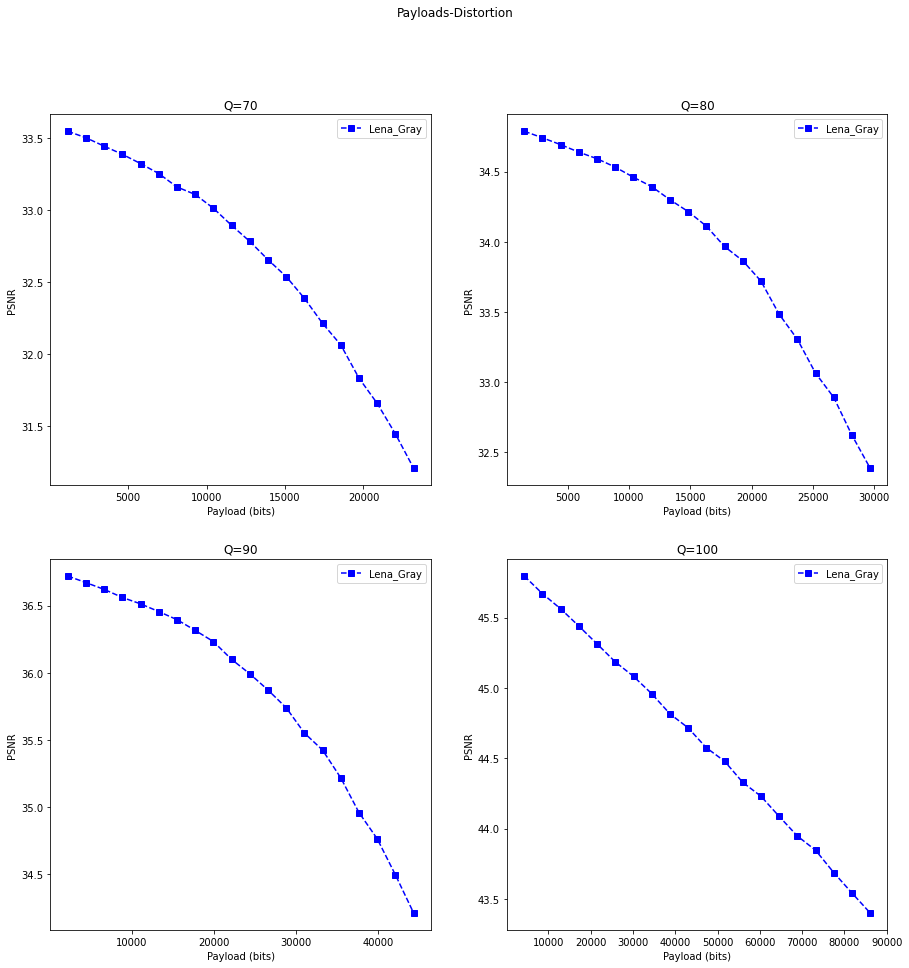

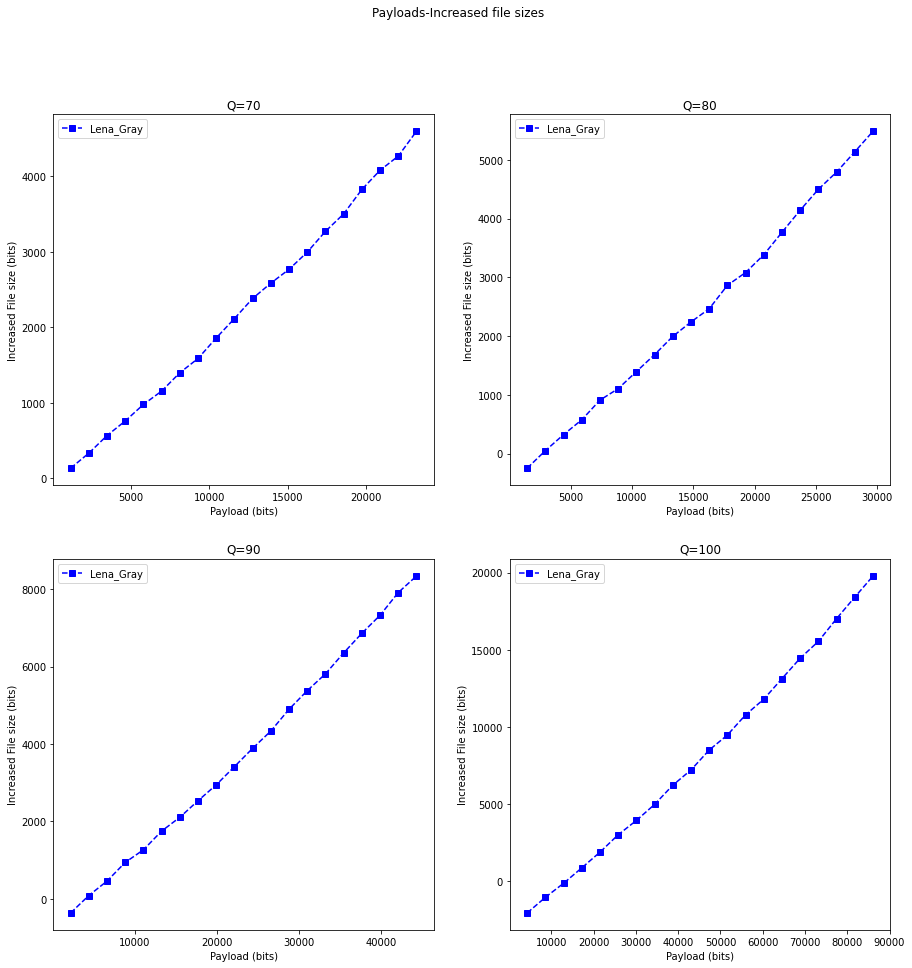

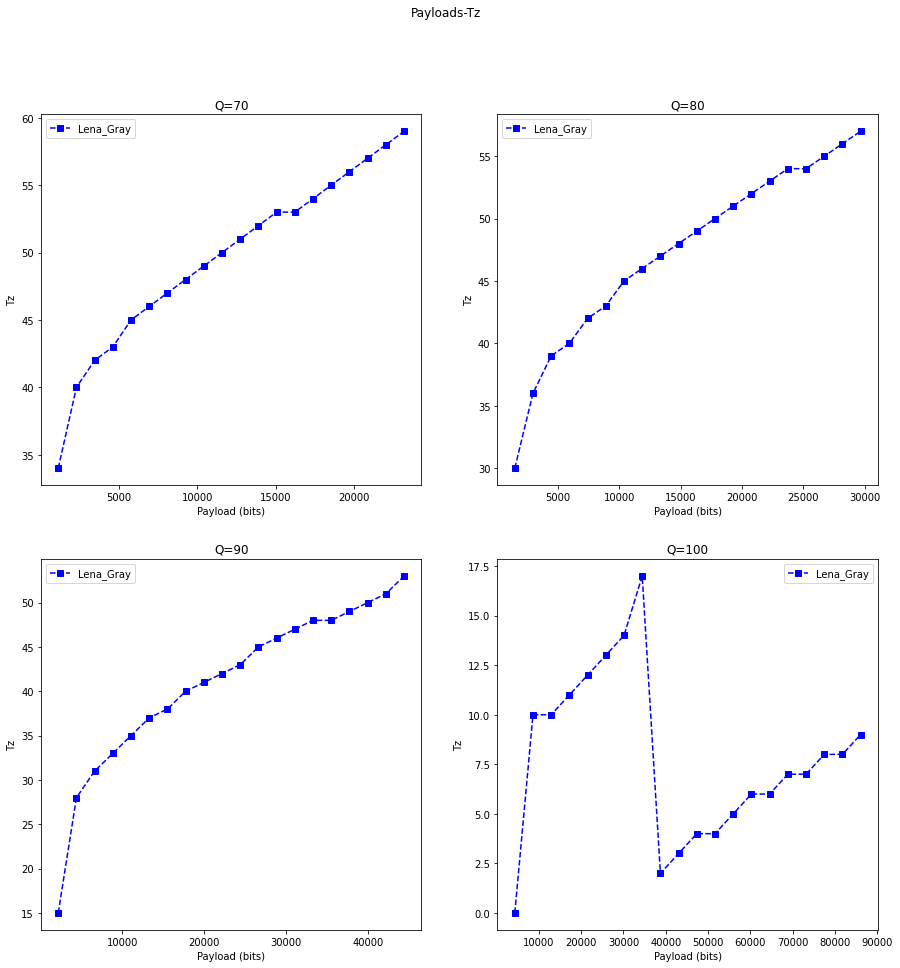

In [54]:
fig12, axs12 = plt.subplots(2, 2, figsize=(15, 15))
fig13, axs13 = plt.subplots(2, 2, figsize=(15, 15))
fig_1, axs_1 = plt.subplots(2, 2, figsize=(15, 15))

# image_set = ["lena_color", "boat", "Baboon", "Peppers"]
image_set = ["Lena_Gray"]
image_set_color = ["bs--"]
# image_set_color = ["b-", "g-", "r-", "c-"]

quality_List = [70, 80, 90, 100]
for image_index in trange(len(image_set)):
    # print("# image:", image_set[image_index])
    for index in range(len(quality_List)):
        # print("## quality:", quality_List[index])

        message_len_List = []
        file_size_List = []
        PSNR_List = []
        Tz_List = []

        origin_image = imageio.imread(image_path)
        origin_jpg_image_path = "{}/{}_Q{}.jpg".format(dir, image_set[image_index], quality_List[index])
        # origin_image_path = "../../_Dataset/Lenna/lena_color.gif"
        origin_jpg_image = imageio.imread(origin_jpg_image_path)
        origin_jpg_image_file_size = Path(origin_jpg_image_path).stat().st_size

        file_paths = Path("{}/".format(dir)).glob("{}_RDH_Propose_Q{}*.jpg".format(image_set[image_index], quality_List[index]))
        # print("number of file:", len(list(file_paths)))

        for file_path in file_paths:
            message_len_List.append(int(str(file_path).split(".")[0].split("_P")[-1]))
            Tz_List.append(int(str(file_path).split(".")[0].split("_T")[-1].split("_")[0]))
            # print("### P:", message_len_List[-1])
            
            image = imageio.imread(file_path)
            file_size_List.append(Path(file_path).stat().st_size)
            PSNR_List.append(psnr(origin_image, image))

        analize = np.zeros((len(message_len_List), 3))
        # print(analize.shape)
        analize[:, 0] = message_len_List
        analize[:, 1] = file_size_List
        analize[:, 2] = PSNR_List

        analize = sorted(analize, key=lambda x: x[0])
        # print(analize[0], analize[-1])

        message_len_List = list(zip(*np.array(analize)))[0]
        file_size_List = list(zip(*np.array(analize)))[1]
        PSNR_List = list(zip(*np.array(analize)))[2]

        increased_file_size_List = np.array(file_size_List) - origin_jpg_image_file_size

        # print("### Payloads-Increased file sizes")
        axs13[index//2, index%2].plot(message_len_List, increased_file_size_List, image_set_color[image_index], label=image_set[image_index])
        axs13[index//2, index%2].set_title("Q={}".format(quality_List[index], 30))
        axs13[index//2, index%2].set_xlabel("Payload (bits)")
        axs13[index//2, index%2].set_ylabel("Increased File size (bits)")
        axs13[index//2, index%2].legend()

        # print("### Payloads-Distortion")
        axs12[index//2, index%2].plot(message_len_List, PSNR_List, image_set_color[image_index], label=image_set[image_index])
        axs12[index//2, index%2].set_title("Q={}".format(quality_List[index], 30))
        axs12[index//2, index%2].set_xlabel("Payload (bits)")
        axs12[index//2, index%2].set_ylabel("PSNR")
        axs12[index//2, index%2].legend()

        axs_1[index//2, index%2].plot(message_len_List, Tz_List, image_set_color[image_index], label=image_set[image_index])
        axs_1[index//2, index%2].set_title("Q={}".format(quality_List[index], 30))
        axs_1[index//2, index%2].set_xlabel("Payload (bits)")
        axs_1[index//2, index%2].set_ylabel("Tz")
        axs_1[index//2, index%2].legend()

fig12.suptitle("Payloads-Distortion")
fig13.suptitle("Payloads-Increased file sizes")
fig_1.suptitle("Payloads-Tz")

plt.show()

In [40]:
reStore_message_len, reStore_Tz

(3000, 57)

In [41]:
reStore_message == message

True

In [42]:
np.array_equal(origin_Blocks, rdh.Blocks)

True

In [43]:
np.argwhere(test == False)

array([], shape=(0, 2), dtype=int64)

In [44]:
z_index, comp_index = 0, 0
origin_Blocks[z_index][comp_index], rdh.Blocks[z_index][comp_index]

(array([26,  1,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([26,  1,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]))

In [231]:
# capa = maxCapacity
capa = 5

L = np.binary_repr(capa)
T = np.binary_repr(rdh.Tz)

In [197]:
np.ceil(np.log2(maxCapacity-len(L)-l2)), len(L)

(15.0, 3)

In [9]:
arr = [0, 1, 4, 7, 13, 15 ,24, 38]
t = -60

def binarySearch_approach(minIndex, maxIndex):
    if minIndex == maxIndex:
        return 0, minIndex
    elif minIndex == maxIndex-1:
        # print(maxIndex)
        if maxIndex == len(arr):
            return minIndex
        else:
            return (1, minIndex if abs(arr[minIndex]-t) < abs(arr[maxIndex]-t) else maxIndex)
    else:
        midIndex = (minIndex+maxIndex)//2
        if arr[midIndex] == t:
            return 2, midIndex
        elif arr[midIndex] > t:
            return binarySearch_approach(minIndex, midIndex)
        else:
            return binarySearch_approach(midIndex, maxIndex)

def binarySearch_least(minIndex, maxIndex):
    print("minIndex={}, maxIndex={}".format(minIndex, maxIndex))
    if minIndex == maxIndex:
        return minIndex
    else:
        midIndex = (minIndex+maxIndex)//2
        if arr[midIndex] == t:
            return midIndex
        elif arr[midIndex] > t:
            return binarySearch_least(minIndex, midIndex)
        else:
            return binarySearch_least(midIndex+1, maxIndex)

print("binarySearch_least", binarySearch_least(0, len(arr)))

minIndex=0, maxIndex=8
minIndex=0, maxIndex=4
minIndex=0, maxIndex=2
minIndex=0, maxIndex=1
minIndex=0, maxIndex=0
binarySearch_least 0


In [198]:
## T length
l2 = len(T)
## message length
l1 = len(L) - (np.ceil(np.log2(maxCapacity-len(L)-l2))<len(L))
l1, l2

(3, 5)

In [183]:
new_maxC = maxCapacity-l1-l2
np.binary_repr(new_maxC), new_maxC

('100110111000010', 19906)

In [169]:
L = np.binary_repr(maxCapacity)
len(test), test

(15, '100110111010110')

In [147]:
ac_list = np.array(ac_list)
ac_list.shape

C:\Users\BREND\AppData\Local\Temp\ipykernel_9168\3408495011.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ac_list = np.array(ac_list)


(4096,)

In [148]:
ac_list[218][0], rdh.Blocks[218][0]

({'NumberOfZeroAC': 60,
  'NumberOfInnerCoefficients': 2,
  'NonZeroAC_index': array([ 0, 11], dtype=uint8)},
 array([-3, -1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]))

In [149]:
test = rdh.normalizationNonZeroAC_index(ac_list)
test

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (1, 0, 2),
 (1, 0, 13),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 4),
 (2, 0, 5),
 (2, 0, 12),
 (3, 0, 4),
 (4, 0, 1),
 (4, 0, 4),
 (4, 0, 6),
 (5, 0, 4),
 (5, 0, 5),
 (6, 0, 1),
 (6, 0, 3),
 (7, 0, 2),
 (7, 0, 3),
 (7, 0, 5),
 (7, 0, 12),
 (7, 0, 13),
 (8, 0, 1),
 (8, 0, 2),
 (8, 0, 3),
 (8, 0, 8),
 (8, 0, 13),
 (8, 0, 15),
 (9, 0, 1),
 (9, 0, 3),
 (9, 0, 7),
 (9, 0, 12),
 (10, 0, 2),
 (11, 0, 0),
 (11, 0, 2),
 (11, 0, 4),
 (12, 0, 0),
 (12, 0, 1),
 (12, 0, 3),
 (12, 0, 4),
 (12, 0, 5),
 (13, 0, 1),
 (13, 0, 13),
 (13, 0, 15),
 (14, 0, 1),
 (14, 0, 2),
 (14, 0, 5),
 (15, 0, 0),
 (15, 0, 1),
 (15, 0, 5),
 (15, 0, 13),
 (15, 0, 15),
 (16, 0, 0),
 (17, 0, 1),
 (17, 0, 2),
 (17, 0, 3),
 (18, 0, 1),
 (18, 0, 5),
 (18, 0, 6),
 (19, 0, 3),
 (20, 0, 0),
 (20, 0, 4),
 (20, 0, 8),
 (22, 0, 0),
 (23, 0, 0),
 (23, 0, 1),
 (23, 0, 3),
 (24, 0, 1),
 (25, 0, 0),
 (25, 0, 1),
 (25, 0, 2),
 (26, 0, 4),
 (26, 0, 5),
 (26, 0, 13),
 (26, 0, 15),
 (27, 0, 13),
 (29, 0, 1),
 (29,

In [150]:
Seed = 7

In [151]:
np.random.seed(Seed)
permutedTest = np.random.permutation(test)
permutedTest

array([[2902,    0,    2],
       [2003,    0,   18],
       [3343,    0,    3],
       ...,
       [1271,    0,   19],
       [2256,    0,   16],
       [3476,    0,   19]], dtype=int64)

In [152]:
permutedTest.shape

(19926, 3)

In [141]:

np.random.seed(Seed)
permutation = list(np.random.permutation(len(test)))
permutedTest = np.squeeze(test[permutation, :, :])

TypeError: list indices must be integers or slices, not tuple